In [1]:
# calculate elapsed time
import time
start_time = time.time()

#### IMPORT

In [2]:
import os, platform
import py7zr

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical 
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, \
    BatchNormalization, Flatten, LSTM
# from scikeras.wrappers import KerasClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import load_model

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc

from itertools import cycle
from scipy import interp
from scipy.optimize import brentq
from scipy.interpolate import interp1d

#### PARAMETERS
- Set the condition
> * N_FEATURES: Number of Features
> * CHECK_BLANKS: Check for blank data. If any blank data is found, the whole row of data will be deleted.
> * CHECK_CLASS_IMBALANCE: Check for dataset class imbalance. The more balance the dataset, the less biases the model will be.

In [3]:
##############################
# # deep learning features # #
##############################
SEED = 1005 # random seed for reproducibility

# should make this dynamic
N_FEATURES = 97
TIMESTEPS = 1
EPOCH=200
BATCH_SIZE=50

SPLIT_RATIO=0.2

###############
# # preview # #
###############
f = False
t = True

# checking dataset
CHECK_BLANKS = True
CHECK_CLASS_IMBALANCE = True

# evaluate suitable kfold number and kfold model
MIN_KFOLD = 2
MAX_KFOLD = 11
N_KFOLD = 5
EVAL_KFOLD_NUM = False
EVAL_KFOLD_MODEL = False
PERFORM_KFOLD = True

# model testing
TEST_MODEL = True
CON_MATRIX = True
ROC_GRAPH = True

###############
# # dataset # #
###############
CLASSES_COL_NAME = "Subject"
CLASSES_COL_NUM = 0
FEATURES_COL_NUM = 2

DATASET_DIR_NAME = "dataset\set03\\01_original_rand"
SAMPLE_DATASET_NAME = "original_train_rand"
ACTUAL_DATASET_NAME = "original_test_rand"

MODEL_DIR_NAME = "dataset\set03\\01_original_rand"
MODEL_NAME = "model_" + "set03_01_original_rand"

RESULT_DIR_NAME = "dataset\set03\\01_original_rand"
RESULT_NAME = "result_" + "set03_01_original_rand"

DATASET_DIR_PATH = os.path.join(os.getcwd(), DATASET_DIR_NAME)
SAMPLE_DATASET_PATH = os.path.join(DATASET_DIR_PATH, SAMPLE_DATASET_NAME + ".csv")
ACTUAL_DATASET_PATH = os.path.join(DATASET_DIR_PATH, ACTUAL_DATASET_NAME + ".csv")

MODEL_DIR_PATH = os.path.join(os.getcwd(), MODEL_DIR_NAME)
MODEL_PATH = os.path.join(MODEL_DIR_PATH, MODEL_NAME + ".h5")

RESULT_DIR_PATH = os.path.join(os.getcwd(), RESULT_DIR_NAME)
RESULT_PATH = os.path.join(RESULT_DIR_PATH, RESULT_NAME + ".csv")

#################
# # sns theme # #
#################
# sns.set_theme(style="darkgrid") # (dark background with white gridlines)
sns.set_theme(style="whitegrid") # (white background with grey gridlines)
# sns.set_theme(style="dark") # (dark background with no gridlines)
# sns.set_theme(style="white") # (white background with no gridlines)
# sns.set_theme(style="ticks") # (white background with axis ticks and no gridlines)

In [4]:
if os.path.isdir(DATASET_DIR_PATH) is True:
    print(f"Dataset directory exists at: {DATASET_DIR_PATH}")
else:
    try:
        os.mkdir(DATASET_DIR_PATH, 666)
        print(f"Dataset directory have been created at: {DATASET_DIR_PATH}")
    except:
        print("Error: Dataset Directory not created")
        
if os.path.isdir(MODEL_DIR_PATH) is True:
    print(f"Model directory exists at: {MODEL_DIR_PATH}")
else:
    try:
        os.mkdir(MODEL_DIR_PATH, 666)
        print(f"Model directory have been created at: {MODEL_DIR_PATH}")
    except:
        print("Error: Model Directory not created")
    
if os.path.exists(SAMPLE_DATASET_PATH) is True:
    print(f"Training dataset exists at: {SAMPLE_DATASET_PATH}")
else:
    try:
        SAMPLE_7Z_PATH = os.path.join(DATASET_DIR_PATH, SAMPLE_DATASET_NAME + ".7z")
        with py7zr.SevenZipFile(SAMPLE_7Z_PATH, mode='r') as z:
            z.extractall(path=DATASET_DIR_PATH)
        print(f"Decompress 7z file to: {SAMPLE_7Z_PATH}")
    except:
        print("Error: Failed to decompress 7z file.")

Dataset directory exists at: C:\Users\andyc\Documents\GitHub\ict4001-cap\dataset\set03\01_original_rand
Model directory exists at: C:\Users\andyc\Documents\GitHub\ict4001-cap\dataset\set03\01_original_rand
Training dataset exists at: C:\Users\andyc\Documents\GitHub\ict4001-cap\dataset\set03\01_original_rand\original_train_rand.csv


#### CREATE MODEL
- Create base model
- Wrap it with KerasClassifier

In [5]:
#create base model
def create_base_model():
    model = Sequential()
    model.add(LSTM(units=256, return_sequences=True,
             input_shape=(TIMESTEPS,N_FEATURES)))
    model.add(Dense(256, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=128, return_sequences=True))
    model.add(Dense(128, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dense(64, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=32, return_sequences=True))
    model.add(Dense(32, activation='sigmoid'))
    model.add(Dropout(0.2))

    # softmax for multi-class classification
    model.add(Flatten())
    print("There are a total of " + str(n_classes) + " classes.")
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam',
                metrics=['accuracy'])
    return model

# wrap model in KerasClassifier
def create_model():
    model = KerasClassifier(build_fn=create_base_model, epochs=EPOCH, 
                            batch_size=BATCH_SIZE)
    return model

In [6]:
# divide data into features X and target (classes) Y
def prepare_dataset(df):
    X = df.values[:,FEATURES_COL_NUM:].astype(float)
    Y = df.values[:,CLASSES_COL_NUM].astype(str)

    # convert target Y to labelbinarizer Y for model
    # fit_transform is not used to reuse lb
    Y = Y.reshape(-1, 1)
    lb = LabelBinarizer().fit(Y)
    Y = lb.transform(Y)

    #################################
    # # get all the encoded class # #
    #################################
    print("LabelBinarizer is able to decipher: ")
    print(lb.classes_)
    print("\n")

    ###########################
    # # print X and Y shape # #
    ###########################
    print(f"X | Features | Dataset Shape: {X.shape}")
    print(f"Y | Classes  | Dataset Shape: {Y.shape}")

    return X, Y, lb, lb.classes_.tolist()

In [7]:
def split_shape_dataset(X, Y, SPLIT_RATIO, TIMESTEPS, SEED):

    ##############################################################
    # # split dataset into train and test set of 0.8/0.2 ratio # #
    ##############################################################
    X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=SPLIT_RATIO, random_state=SEED)

    ############################
    # # reshaping of dataset # #
    ############################

    # reshaping the dataset to include LSTM Timesteps
    print(X_train.dtype)
    X_train = np.asarray(X_train, dtype=np.float32)
    print(X_train.dtype)
    X_train = np.reshape(X_train, (X_train.shape[0], TIMESTEPS, X_train.shape[1]))
    print(X_test.dtype)
    X_test = np.asarray(X_test, dtype=np.float32)
    print(X_test.dtype)
    X_test = np.reshape(X_test, (X_test.shape[0], TIMESTEPS, X_test.shape[1]))

    print(f"X train shape: {X_train.shape}")
    print(f"Y train shape: {y_train.shape}")
    print(f"X test shape: {X_test.shape}")
    print(f"Y test shape: {y_test.shape}")
    
    return X_train, X_test, y_train, y_test

def reshape_dataset(X, TIMESTEPS):
    # reshaping the dataset to include LSTM Timesteps
    X = np.asarray(X, dtype=np.float32)
    X = np.reshape(X, (X.shape[0], TIMESTEPS, X.shape[1]))
    return X

#### LOAD DATASET

In [8]:
# load dataset
df = pd.read_csv(SAMPLE_DATASET_PATH)
df.head()

,Subject,Sequence,T2-D|0,T2-I|0+1,T2-PF|0+1,T2-RF|0+1,T2-NG|0+1,T2-D|1,T2-I|1+2,T2-PF|1+2,...,T4-RF|VAR,T4-NG|VAR,T4-I|SD,T4-PF|SD,T4-RF|SD,T4-NG|SD,T5-I|0+4,T5-PF|0+4,T5-RF|0+4,T5-NG|0+4
0,adhy,apish,0.176624,-0.081235,0.095389,0.054188,0.230811,0.135423,-0.079058,0.056365,...,0.000098,0.001523,0.006877,0.022257,0.009891,0.039024,0.183280,0.359904,0.271153,0.447777
1,adhy,aargh,0.120374,0.072112,0.192487,0.239215,0.359589,0.167103,-0.032174,0.134929,...,0.018428,0.010549,0.106929,0.073887,0.135748,0.102706,0.568097,0.688471,0.671329,0.791703
2,adhy,terry,0.103403,-0.015979,0.087424,0.152003,0.255405,0.167982,-0.032004,0.135978,...,0.009239,0.002546,0.056287,0.010623,0.096118,0.050453,0.328402,0.431805,0.384529,0.487932
3,adhy,decaf,0.095771,0.079566,0.175337,0.175467,0.271238,0.095901,0.121074,0.216976,...,0.004547,0.004534,0.078745,0.078653,0.067429,0.067337,0.519806,0.615577,0.648569,0.744340
4,adhy,muser,0.112793,0.087803,0.200596,0.192014,0.304807,0.104211,0.071961,0.176172,...,0.012902,0.014318,0.045071,0.051139,0.113588,0.119657,0.448259,0.561053,0.519647,0.632440


#### CHECK DATASET

Checking for blanks...
No blank value has been found.
Checking for class imbalance...


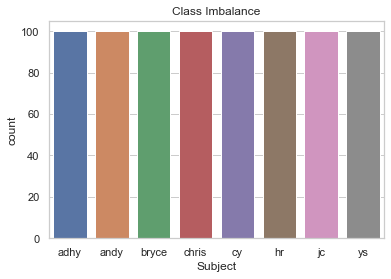

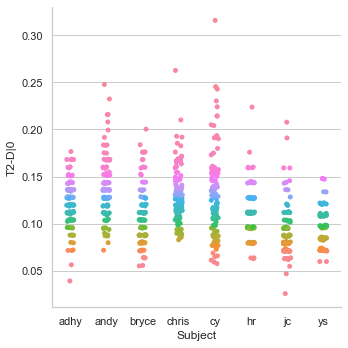

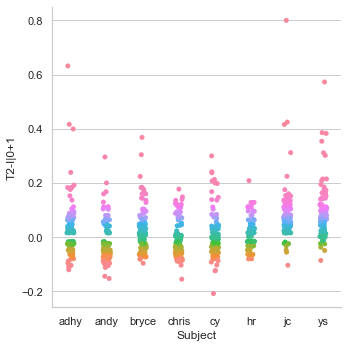

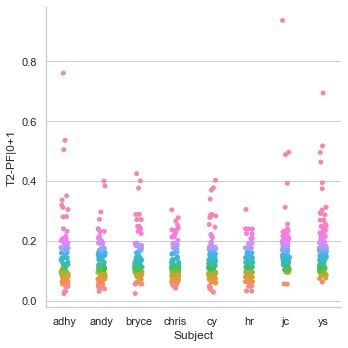

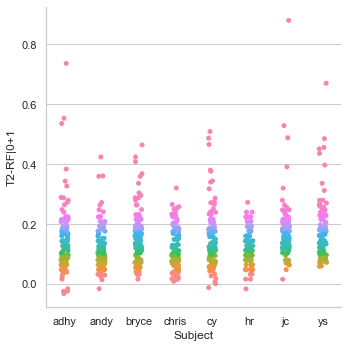

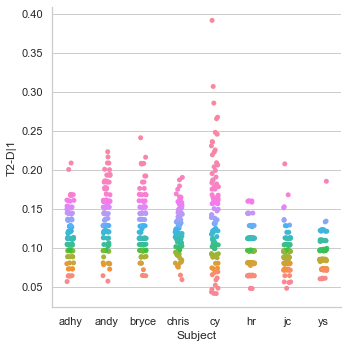

In [9]:
########################
# # check for blanks # #
########################
if CHECK_BLANKS is True:
    # checking for blanks
    print("Checking for blanks...")
    if df.isnull().values.any() is True:
        df = df.dropna(axis=0, how="any")
        print("Blank rows has been dropped.")
    else:
        print("No blank value has been found.")
        
#################################
# # check for class imbalance # #
#################################
if CHECK_CLASS_IMBALANCE is True:
    print("Checking for class imbalance...")
    sns.countplot(x=CLASSES_COL_NAME, data=df).set_title("Class Imbalance")
#     df.loc[(df!=0).any(axis=1)]
    plt.show()

sns.catplot(x="Subject", y="T2-D|0", hue="T2-D|0", data=df, legend=False)
sns.catplot(x="Subject", y="T2-I|0+1", hue="T2-I|0+1", data=df, legend=False)
sns.catplot(x="Subject", y="T2-PF|0+1", hue="T2-PF|0+1", data=df, legend=False)
sns.catplot(x="Subject", y="T2-RF|0+1", hue="T2-RF|0+1", data=df, legend=False)
sns.catplot(x="Subject", y="T2-D|1", hue="T2-D|1", data=df, legend=False)

#### PREPARE DATASET
- Split data based on X / Features and Y / Classes
- Binarize Y into binary labels

In [10]:
X, Y, lb, class_list = prepare_dataset(df)
n_classes = len(class_list)
print(f"Number of Classes: {n_classes}")

LabelBinarizer is able to decipher: 
['adhy' 'andy' 'bryce' 'chris' 'cy' 'hr' 'jc' 'ys']


X | Features | Dataset Shape: (800, 97)
Y | Classes  | Dataset Shape: (800, 8)
Number of Classes: 8


#### SPLIT DATASET
- Split dataset into train set and test set 0.8 / 0.2

In [11]:
##############################################################
# # split dataset into train and test set of 0.8/0.2 ratio # #
##############################################################
X_train, X_test, y_train, y_test = split_shape_dataset(X, Y, SPLIT_RATIO, TIMESTEPS, SEED)

float64
float32
float64
float32
X train shape: (640, 1, 97)
Y train shape: (640, 8)
X test shape: (160, 1, 97)
Y test shape: (160, 8)


#### PERFORM VALIDATION (w KFold Validation)
- Evaluate best KFold Validation
- Generate loss and accuracy graph
- Perform KFold validation

##### Evaluate suitable folds for kfold validation

In [12]:
###############################################
# # evaluate suitable kfold value for model # #
###############################################
def evaluate_kfold(X_train, y_train, SEED, MIN_KFOLD, MAX_KFOLD):
    
    # evaluate the model    
    folds = range(MIN_KFOLD, MAX_KFOLD)
    means, mins, maxs = list(), list(), list()
    
    # evaluate each k value
    for k in folds:
        # define the test condition
        kfold = KFold(n_splits=k, shuffle=True, random_state=SEED)
        
        # evaluate k value
        model = create_model()
        scores = cross_val_score(model, X_train, y_train, cv=kfold, n_jobs=-1)
        
        k_mean = np.mean(scores)
        k_min = scores.min()
        k_max = scores.max()
        
        # report performance
        print(f"No. of Folds: {k} | Accuracy: {k_mean*100:.3f} | Min: {k_min*100:.3f} | Max: {k_max*100:.3f}")
        
        # store mean accuracy and min and max relative to the mean
        means.append(k_mean)
        mins.append(k_mean - k_min)
        maxs.append(k_max - k_mean)
        
    # line plot of k mean values with min/max error bars
    clear_output(wait=True)
    pyplot.errorbar(folds, means, yerr=[mins, maxs], fmt='o')
    
    # show the plot
    pyplot.show()
    
if EVAL_KFOLD_NUM is True:
    evaluate_kfold(X_train, y_train, SEED, MIN_KFOLD, MAX_KFOLD)
else:
    print("EVAL_KFOLD_NUM is not True")

EVAL_KFOLD_NUM is not True


##### Generate kfold validation accuracy and loss

In [13]:
##################################################
# # evaluate kfold model for accuracy and loss # #
##################################################
def evaluate_kfold_model(X_train, y_train, SEED):
    scores, histories = list(), list()
    # create model
    model = create_model()
    # prepare cross validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)
    # enumerate splits
    for train_ix, test_ix in kfold.split(X_train):
        # select rows for train and test
        trainX, trainY, testX, testY = X_train[train_ix], y_train[train_ix], X_train[test_ix], y_train[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=100, batch_size=50, validation_data=(testX, testY), verbose=0)
        
        # evaluate model
        y_pred = model.predict(testX)
        y_pred = to_categorical(y_pred)

        # evaluate predictions
        acc = accuracy_score(testY, y_pred)
        print("Testing accuracy: %.3f%%" % (acc*100))

        # stores scores and histories
        scores.append(acc)
        histories.append(history)

    for i in range(len(histories)):
        # plot loss
        f1 = plt.figure(1)
        plt.title('Categorical Cross-Entropy Loss')
        plt.plot(histories[i].history['loss'], color='blue')
        plt.plot(histories[i].history['val_loss'], color='orange')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper right')

        # plot accuracy
        f2 = plt.figure(2)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['accuracy'], color='blue')
        plt.plot(histories[i].history['val_accuracy'], color='orange')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='lower right')

    # print summary
    print(f"Accuracy | Mean: {np.mean(scores)*100:.3f} | Std: {np.std(scores)*100:.3f} | Length/no.: {len(scores)}")
    # box and whisker plots of results
    f3 = plt.figure(3)
    plt.title('Box and Whisker Plot of Accuracy Scores')
    plt.ylabel('accuracy')
    plt.xlabel('model')
    plt.boxplot(scores)
    clear_output(wait=True)
    plt.show()
    
if EVAL_KFOLD_MODEL is True:
    evaluate_kfold_model(X_train, y_train, SEED)
else:
    print("EVAL_KFOLD_MODEL is not true")

EVAL_KFOLD_MODEL is not true


##### Perform Actual KFold validation

In [14]:
if PERFORM_KFOLD is True:
    # create model
    model = create_model()
    kfold = KFold(n_splits=N_KFOLD, shuffle=True, random_state=SEED)
    valid_score = cross_val_score(model, X_train, y_train, 
                          cv=kfold, error_score="raise", verbose=0)
else:
    print("PERFORM_KFOLD is not true.")

There are a total of 8 classes.
Epoch 1/200
11/11 [==============================] - 7s 11ms/step - loss: 2.5413 - accuracy: 0.0938
Epoch 2/200
11/11 [==============================] - 0s 12ms/step - loss: 2.4462 - accuracy: 0.1074
Epoch 3/200
11/11 [==============================] - 0s 12ms/step - loss: 2.3523 - accuracy: 0.1152
Epoch 4/200
11/11 [==============================] - 0s 12ms/step - loss: 2.3006 - accuracy: 0.1094
Epoch 5/200
11/11 [==============================] - 0s 12ms/step - loss: 2.2665 - accuracy: 0.1152
Epoch 6/200
11/11 [==============================] - 0s 12ms/step - loss: 2.2270 - accuracy: 0.0957
Epoch 7/200
11/11 [==============================] - 0s 13ms/step - loss: 2.2081 - accuracy: 0.1133
Epoch 8/200
11/11 [==============================] - 0s 13ms/step - loss: 2.1899 - accuracy: 0.0996
Epoch 9/200
11/11 [==============================] - 0s 12ms/step - loss: 2.1697 - accuracy: 0.1133
Epoch 10/200
11/11 [==============================] - 0s 12ms/step -

11/11 [==============================] - 0s 17ms/step - loss: 1.6260 - accuracy: 0.3105
Epoch 162/200
11/11 [==============================] - 0s 16ms/step - loss: 1.6157 - accuracy: 0.3105
Epoch 163/200
11/11 [==============================] - 0s 16ms/step - loss: 1.5893 - accuracy: 0.3418
Epoch 164/200
11/11 [==============================] - 0s 17ms/step - loss: 1.6468 - accuracy: 0.3223
Epoch 165/200
11/11 [==============================] - 0s 17ms/step - loss: 1.6317 - accuracy: 0.3242
Epoch 166/200
11/11 [==============================] - 0s 17ms/step - loss: 1.6210 - accuracy: 0.3535
Epoch 167/200
11/11 [==============================] - 0s 16ms/step - loss: 1.6510 - accuracy: 0.3066
Epoch 168/200
11/11 [==============================] - 0s 17ms/step - loss: 1.6293 - accuracy: 0.3379
Epoch 169/200
11/11 [==============================] - 0s 17ms/step - loss: 1.6594 - accuracy: 0.3242
Epoch 170/200
11/11 [==============================] - 0s 16ms/step - loss: 1.6275 - accuracy: 0

11/11 [==============================] - 0s 12ms/step - loss: 1.5952 - accuracy: 0.3477
Epoch 122/200
11/11 [==============================] - 0s 13ms/step - loss: 1.6061 - accuracy: 0.3418
Epoch 123/200
11/11 [==============================] - 0s 13ms/step - loss: 1.6078 - accuracy: 0.3320
Epoch 124/200
11/11 [==============================] - 0s 13ms/step - loss: 1.6077 - accuracy: 0.3574
Epoch 125/200
11/11 [==============================] - 0s 13ms/step - loss: 1.6108 - accuracy: 0.3691
Epoch 126/200
11/11 [==============================] - 0s 12ms/step - loss: 1.6053 - accuracy: 0.3418
Epoch 127/200
11/11 [==============================] - 0s 13ms/step - loss: 1.6215 - accuracy: 0.3320
Epoch 128/200
11/11 [==============================] - 0s 13ms/step - loss: 1.6156 - accuracy: 0.3301
Epoch 129/200
11/11 [==============================] - 0s 13ms/step - loss: 1.6066 - accuracy: 0.3301
Epoch 130/200
11/11 [==============================] - 0s 13ms/step - loss: 1.6309 - accuracy: 0

11/11 [==============================] - 0s 11ms/step - loss: 1.6722 - accuracy: 0.2891
Epoch 82/200
11/11 [==============================] - 0s 11ms/step - loss: 1.6806 - accuracy: 0.2930
Epoch 83/200
11/11 [==============================] - 0s 11ms/step - loss: 1.6742 - accuracy: 0.3301
Epoch 84/200
11/11 [==============================] - 0s 12ms/step - loss: 1.6723 - accuracy: 0.3008
Epoch 85/200
11/11 [==============================] - 0s 11ms/step - loss: 1.6848 - accuracy: 0.3008
Epoch 86/200
11/11 [==============================] - 0s 12ms/step - loss: 1.7033 - accuracy: 0.2754
Epoch 87/200
11/11 [==============================] - 0s 12ms/step - loss: 1.7247 - accuracy: 0.2832
Epoch 88/200
11/11 [==============================] - 0s 11ms/step - loss: 1.7105 - accuracy: 0.2949
Epoch 89/200
11/11 [==============================] - 0s 11ms/step - loss: 1.7150 - accuracy: 0.3105
Epoch 90/200
11/11 [==============================] - 0s 12ms/step - loss: 1.7200 - accuracy: 0.2793
Epo

11/11 [==============================] - 0s 13ms/step - loss: 1.8159 - accuracy: 0.2441
Epoch 41/200
11/11 [==============================] - 0s 14ms/step - loss: 1.8202 - accuracy: 0.2422
Epoch 42/200
11/11 [==============================] - 0s 14ms/step - loss: 1.8431 - accuracy: 0.2402
Epoch 43/200
11/11 [==============================] - 0s 12ms/step - loss: 1.8223 - accuracy: 0.2480
Epoch 44/200
11/11 [==============================] - 0s 12ms/step - loss: 1.8450 - accuracy: 0.2441
Epoch 45/200
11/11 [==============================] - 0s 18ms/step - loss: 1.8206 - accuracy: 0.2637
Epoch 46/200
11/11 [==============================] - 0s 15ms/step - loss: 1.7969 - accuracy: 0.2734
Epoch 47/200
11/11 [==============================] - 0s 14ms/step - loss: 1.7840 - accuracy: 0.2676
Epoch 48/200
11/11 [==============================] - 0s 13ms/step - loss: 1.8136 - accuracy: 0.2637
Epoch 49/200
11/11 [==============================] - 0s 13ms/step - loss: 1.7744 - accuracy: 0.2871
Epo

11/11 [==============================] - 0s 12ms/step - loss: 1.6741 - accuracy: 0.3125
Epoch 122/200
11/11 [==============================] - 0s 12ms/step - loss: 1.6504 - accuracy: 0.3281
Epoch 123/200
11/11 [==============================] - 0s 12ms/step - loss: 1.6553 - accuracy: 0.3125
Epoch 124/200
11/11 [==============================] - 0s 12ms/step - loss: 1.6548 - accuracy: 0.3203
Epoch 125/200
11/11 [==============================] - 0s 12ms/step - loss: 1.6746 - accuracy: 0.3184
Epoch 126/200
11/11 [==============================] - 0s 12ms/step - loss: 1.6796 - accuracy: 0.3086
Epoch 127/200
11/11 [==============================] - 0s 12ms/step - loss: 1.6682 - accuracy: 0.3086
Epoch 128/200
11/11 [==============================] - 0s 13ms/step - loss: 1.6538 - accuracy: 0.3281
Epoch 129/200
11/11 [==============================] - 0s 12ms/step - loss: 1.6840 - accuracy: 0.3184
Epoch 130/200
11/11 [==============================] - 0s 12ms/step - loss: 1.6344 - accuracy: 0

11/11 [==============================] - 0s 12ms/step - loss: 1.6910 - accuracy: 0.3008
Epoch 82/200
11/11 [==============================] - 0s 12ms/step - loss: 1.6788 - accuracy: 0.3223
Epoch 83/200
11/11 [==============================] - 0s 12ms/step - loss: 1.6618 - accuracy: 0.3223
Epoch 84/200
11/11 [==============================] - 0s 12ms/step - loss: 1.6392 - accuracy: 0.3086
Epoch 85/200
11/11 [==============================] - 0s 12ms/step - loss: 1.6837 - accuracy: 0.3105
Epoch 86/200
11/11 [==============================] - 0s 12ms/step - loss: 1.6605 - accuracy: 0.3438
Epoch 87/200
11/11 [==============================] - 0s 11ms/step - loss: 1.7089 - accuracy: 0.3105
Epoch 88/200
11/11 [==============================] - 0s 12ms/step - loss: 1.6334 - accuracy: 0.3398
Epoch 89/200
11/11 [==============================] - 0s 12ms/step - loss: 1.6804 - accuracy: 0.3125
Epoch 90/200
11/11 [==============================] - 0s 12ms/step - loss: 1.6542 - accuracy: 0.3105
Epo

##### Get Validation Accuracy

In [15]:
if PERFORM_KFOLD is True:
    print("Validation Accuracy of %.2f%% (with standard deviation of %.2f%%)" % 
      (valid_score.mean()*100, valid_score.std()*100))
else:
    print("PERFORM_KFOLD is not true.")

Validation Accuracy of 29.22% (with standard deviation of 4.38%)


#### FIT MODEL FOR TESTING
- Fit the Model
- View Accuracy and Loss Graph
- View Model Summary

In [16]:
#####################
# # fit the model # #
#####################

if TEST_MODEL is True:
    model = create_model()
    es = EarlyStopping(monitor='loss', mode='min', min_delta=0.001, patience=50,
                       verbose=1)
    history = model.fit(X_train, y_train, callbacks=es, verbose=1)

There are a total of 8 classes.
Epoch 1/200
13/13 [==============================] - 7s 14ms/step - loss: 2.3239 - accuracy: 0.1469
Epoch 2/200
13/13 [==============================] - 0s 13ms/step - loss: 2.2385 - accuracy: 0.1391
Epoch 3/200
13/13 [==============================] - 0s 13ms/step - loss: 2.1745 - accuracy: 0.1406
Epoch 4/200
13/13 [==============================] - 0s 13ms/step - loss: 2.1393 - accuracy: 0.1141
Epoch 5/200
13/13 [==============================] - 0s 13ms/step - loss: 2.1147 - accuracy: 0.1312
Epoch 6/200
13/13 [==============================] - 0s 13ms/step - loss: 2.1222 - accuracy: 0.1141
Epoch 7/200
13/13 [==============================] - 0s 14ms/step - loss: 2.1242 - accuracy: 0.0953
Epoch 8/200
13/13 [==============================] - 0s 13ms/step - loss: 2.1305 - accuracy: 0.1031
Epoch 9/200
13/13 [==============================] - 0s 13ms/step - loss: 2.1068 - accuracy: 0.1344
Epoch 10/200
13/13 [==============================] - 0s 13ms/step -

13/13 [==============================] - 0s 17ms/step - loss: 1.5237 - accuracy: 0.4109
Epoch 162/200
13/13 [==============================] - 0s 14ms/step - loss: 1.5304 - accuracy: 0.3844
Epoch 163/200
13/13 [==============================] - 0s 15ms/step - loss: 1.5151 - accuracy: 0.3922
Epoch 164/200
13/13 [==============================] - 0s 15ms/step - loss: 1.5123 - accuracy: 0.3812
Epoch 165/200
13/13 [==============================] - 0s 18ms/step - loss: 1.5108 - accuracy: 0.4016
Epoch 166/200
13/13 [==============================] - 0s 17ms/step - loss: 1.5073 - accuracy: 0.4125
Epoch 167/200
13/13 [==============================] - 0s 16ms/step - loss: 1.5262 - accuracy: 0.3875
Epoch 168/200
13/13 [==============================] - 0s 15ms/step - loss: 1.5029 - accuracy: 0.4000
Epoch 169/200
13/13 [==============================] - 0s 16ms/step - loss: 1.4850 - accuracy: 0.4031
Epoch 170/200
13/13 [==============================] - 0s 17ms/step - loss: 1.4763 - accuracy: 0

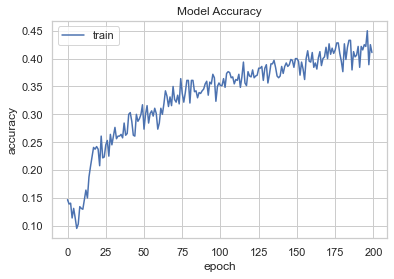

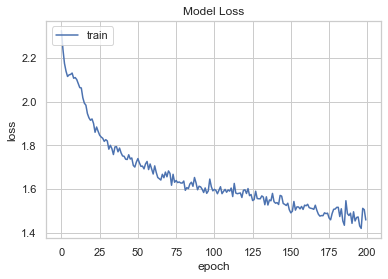

In [17]:
if TEST_MODEL is True:
    ##########################
    # # get model accuracy # #
    ##########################
    plt.plot(history.history['accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

    ######################
    # # get model loss # #
    ######################
    plt.plot(history.history['loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

In [18]:
if TEST_MODEL is True:
    ##########################
    # # view model summary # #
    ##########################
    model.model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 1, 256)            362496    
                                                                 
 dense_25 (Dense)            (None, 1, 256)            65792     
                                                                 
 dropout_20 (Dropout)        (None, 1, 256)            0         
                                                                 
 batch_normalization_15 (Bat  (None, 1, 256)           1024      
 chNormalization)                                                
                                                                 
 lstm_21 (LSTM)              (None, 1, 128)            197120    
                                                                 
 dense_26 (Dense)            (None, 1, 128)            16512     
                                                      

#### MODEL TESTING
- Get Model Accuracy on the Test Dataset
- Generate Confusion Matrix
- Generate ROC Curves
- Save the Model if Appropriate

In [19]:
if TEST_MODEL is True:
    y_pred = model.predict_proba(X_test)

    # evaluate predictions
    acc = accuracy_score(lb.inverse_transform(y_test), lb.inverse_transform(y_pred))
    print("Testing accuracy: %.3f%%" % (acc*100))

Testing accuracy: 32.500%


##### Confusion Matrix

160 is the number of test value in kfold_val / train_test_split


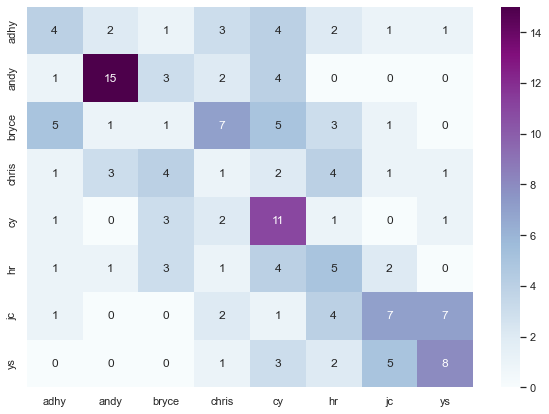

In [20]:
if TEST_MODEL is True and CON_MATRIX is True:
    # confusion matrix
    print(str(len(y_pred)) + " is the number of test value in kfold_val / train_test_split")
    cm = confusion_matrix(lb.inverse_transform(y_test), lb.inverse_transform(y_pred))
    df_cm = pd.DataFrame(cm, index = [i for i in np.unique(lb.inverse_transform(y_test))],
                         columns = [i for i in np.unique(lb.inverse_transform(y_test))])

    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True, cmap="BuPu")

##### ROC Curve (Individual)

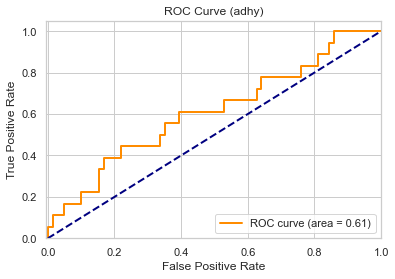

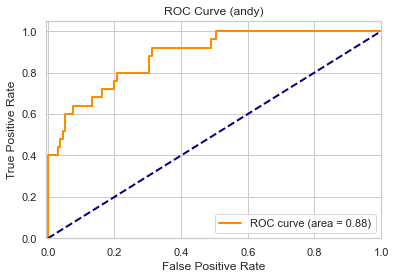

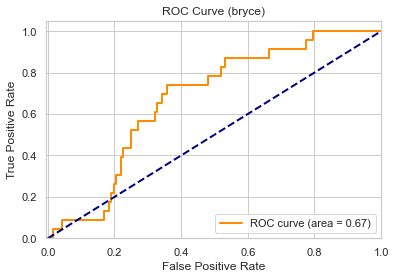

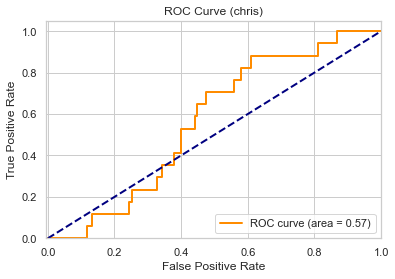

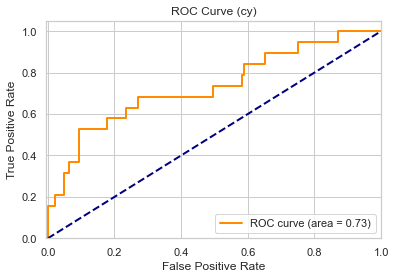

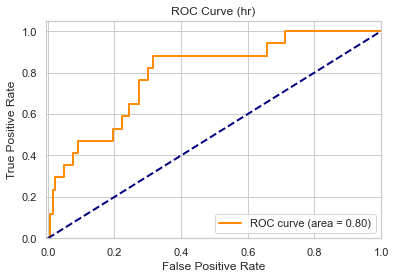

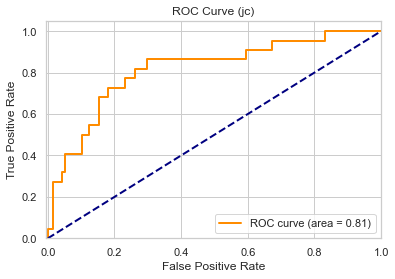

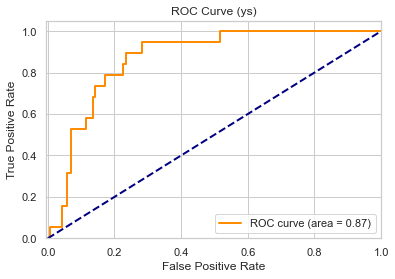

In [21]:
if TEST_MODEL is True and ROC_GRAPH is True: # compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    for i in range(n_classes):
        plt.figure()
        lw = 2
        plt.plot(
            fpr[i],
            tpr[i],
            color="darkorange",
            lw=lw,
            label="ROC curve (area = %0.2f)" % roc_auc[i],
        )
        plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
        plt.xlim([-0.005, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve (" + str(lb.classes_[i]) + ")")
        plt.legend(loc="lower right")
        plt.show()

##### ROC Curve (Multiclass)

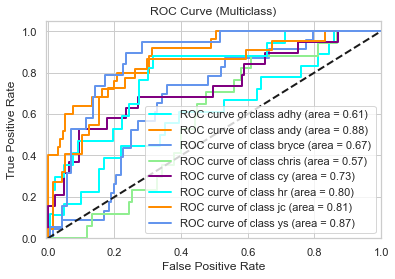

In [22]:
if TEST_MODEL is True and ROC_GRAPH is True:
    # compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], thresholds = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # first aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    # plt.figure()
    # plt.plot(
    #     fpr["micro"],
    #     tpr["micro"],
    #     label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    #     color="deeppink",
    #     linestyle=":",
    #     linewidth=4,
    # )

    # plt.plot(
    #     fpr["macro"],
    #     tpr["macro"],
    #     label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    #     color="navy",
    #     linestyle=":",
    #     linewidth=4,
    # )

    colors = cycle(["aqua", "darkorange", "cornflowerblue", "lightgreen", "purple"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(lb.classes_[i], roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([-0.005, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Multiclass)")
    plt.legend(loc="lower right")
    plt.show()

##### ROC Curve (Average)

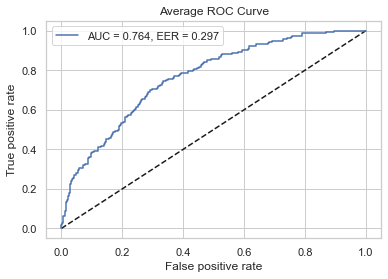

In [23]:
if TEST_MODEL is True and ROC_GRAPH is True:
    fpr, tpr, threshold = roc_curve(y_test.ravel(), y_pred.ravel())

    # calculate equal-error-rate
    eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='AUC = {:.3f}, EER = {:.3f}'.format(auc(fpr, tpr), eer))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('Average ROC Curve')
    plt.legend(loc='best')
    plt.show()

#### FIT AND SAVE MODEL
- Fitting of model
- Get Accuracy and Loss of Mdoel
- Saving Model

In [24]:
############################
# # reshaping of dataset # #
############################
# loading of dataset
df = pd.read_csv(SAMPLE_DATASET_PATH)

df.head()
dataset = df.values

# divide data into features X and target (classes) Y
# convert target Y to labelbinarizer Y for model
X, Y, lb, class_list = prepare_dataset(df)

# reshaping the dataset to include LSTM Timesteps
X = reshape_dataset(X, TIMESTEPS)
n_classes = Y.shape[1]

#####################
# # fit the model # #
#####################

model = create_model()
es = EarlyStopping(monitor='loss', mode='min', min_delta=0.001, patience=50,
                   verbose=0)
history = model.fit(X, Y, callbacks=es)

LabelBinarizer is able to decipher: 
['adhy' 'andy' 'bryce' 'chris' 'cy' 'hr' 'jc' 'ys']


X | Features | Dataset Shape: (800, 97)
Y | Classes  | Dataset Shape: (800, 8)
There are a total of 8 classes.
Epoch 1/200
16/16 [==============================] - 5s 10ms/step - loss: 2.2725 - accuracy: 0.1213
Epoch 2/200
16/16 [==============================] - 0s 9ms/step - loss: 2.1912 - accuracy: 0.1363
Epoch 3/200
16/16 [==============================] - 0s 9ms/step - loss: 2.1515 - accuracy: 0.1300
Epoch 4/200
16/16 [==============================] - 0s 9ms/step - loss: 2.1361 - accuracy: 0.1163
Epoch 5/200
16/16 [==============================] - 0s 10ms/step - loss: 2.1359 - accuracy: 0.1200
Epoch 6/200
16/16 [==============================] - 0s 10ms/step - loss: 2.1265 - accuracy: 0.1312
Epoch 7/200
16/16 [==============================] - 0s 10ms/step - loss: 2.1293 - accuracy: 0.1238
Epoch 8/200
16/16 [==============================] - 0s 10ms/step - loss: 2.1222 - accuracy: 0.1350
E

16/16 [==============================] - 0s 10ms/step - loss: 1.5723 - accuracy: 0.3525
Epoch 161/200
16/16 [==============================] - 0s 10ms/step - loss: 1.5830 - accuracy: 0.3738
Epoch 162/200
16/16 [==============================] - 0s 10ms/step - loss: 1.5922 - accuracy: 0.3650
Epoch 163/200
16/16 [==============================] - 0s 10ms/step - loss: 1.5609 - accuracy: 0.3800
Epoch 164/200
16/16 [==============================] - 0s 10ms/step - loss: 1.5719 - accuracy: 0.3787
Epoch 165/200
16/16 [==============================] - 0s 10ms/step - loss: 1.5624 - accuracy: 0.3587
Epoch 166/200
16/16 [==============================] - 0s 10ms/step - loss: 1.5755 - accuracy: 0.3700
Epoch 167/200
16/16 [==============================] - 0s 10ms/step - loss: 1.5822 - accuracy: 0.3638
Epoch 168/200
16/16 [==============================] - 0s 10ms/step - loss: 1.5644 - accuracy: 0.3625
Epoch 169/200
16/16 [==============================] - 0s 10ms/step - loss: 1.5742 - accuracy: 0

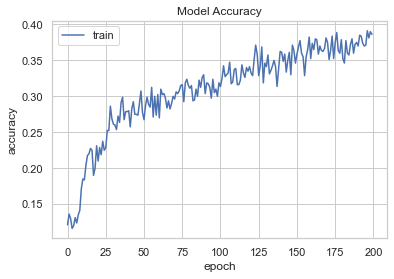

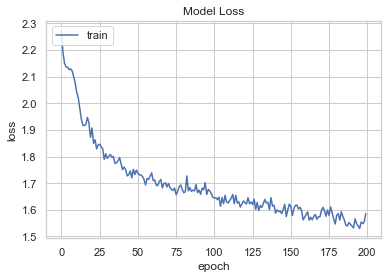

In [25]:
##########################
# # get model accuracy # #
##########################
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

######################
# # get model loss # #
######################
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

#### SAVE MODEL

In [26]:
##################
# # save model # #
##################
model.model.save(MODEL_PATH)

# LIVE TESTING
> Live test with new dataset to check if model function as it should

#### LOAD MODEL

In [27]:
##################
# # load model # #
##################

# model = create_model()
model = load_model(MODEL_PATH)

#### LOAD DATA
- Import new dataset to verify the model is able to predict accurately

In [28]:
# import unseen data
pred_df = pd.read_csv(ACTUAL_DATASET_PATH)
pred_df.head()

,Subject,Sequence,T2-D|0,T2-I|0+1,T2-PF|0+1,T2-RF|0+1,T2-NG|0+1,T2-D|1,T2-I|1+2,T2-PF|1+2,...,T4-RF|VAR,T4-NG|VAR,T4-I|SD,T4-PF|SD,T4-RF|SD,T4-NG|SD,T5-I|0+4,T5-PF|0+4,T5-RF|0+4,T5-NG|0+4
0,adhy,quell,0.120807,-0.024914,0.095893,0.127188,0.247994,0.152102,-0.024045,0.128057,...,3.940000e-05,0.000807,0.005043,0.017085,0.006280,0.028408,0.328119,0.448926,0.416039,0.536846
1,adhy,pizza,0.159790,-0.047984,0.111806,0.087697,0.247487,0.135681,0.023842,0.159523,...,9.412329e-03,0.006395,0.062381,0.045333,0.097017,0.079969,0.423147,0.582937,0.551112,0.710902
2,adhy,yahoo,0.119425,0.015744,0.135168,0.136153,0.255577,0.120409,-0.040412,0.079997,...,3.720000e-07,0.000002,0.006328,0.005632,0.000610,0.001306,0.335316,0.454740,0.408114,0.527538
3,adhy,ogler,0.072609,0.719367,0.791976,0.846915,0.919525,0.127549,-0.047783,0.079765,...,3.322198e-01,0.288946,0.525115,0.486267,0.576385,0.537537,1.078749,1.151358,1.166748,1.239357
4,adhy,cheat,0.120612,-0.056471,0.064141,0.079218,0.199830,0.135689,0.023985,0.159674,...,3.054200e-04,0.000046,0.034640,0.045301,0.017476,0.006815,0.352062,0.472674,0.439222,0.559834


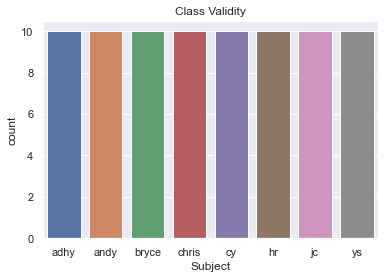

In [29]:
################################
# # check for class validity # #
################################
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Subject", data=pred_df).set_title("Class Validity")

# remove missing values if available
pred_df = pred_df.dropna()

In [30]:
pred_dataset = pred_df.values
actual_np = pred_dataset[:,CLASSES_COL_NUM]

# # divide data into features X
# pred_row = pred_dataset[:,3:].astype(float)

########################
# # predict all rows # #
########################
pred_row=pred_df.iloc[:,FEATURES_COL_NUM:]

#################################
# # predict more than one row # #
#################################

# pred_row=pred_df.iloc[46:54,FEATURES_COL_NUM:]
# print(pred_row)

############################
# # predict a single row # #
############################

# pred_row=pred_df.iloc[11:12,FEATURES_COL_NUM:]

##################
# # shape data # #
##################
pred_row = pred_row.values.tolist()
pred_arr = np.asarray(pred_row, dtype=np.float32)
pred_arr = np.reshape(pred_arr, (pred_arr.shape[0], TIMESTEPS, pred_arr.shape[1]))

print(class_list)
Y = np.asarray(class_list)
Y = Y.reshape(-1, 1)
lb = LabelBinarizer().fit(Y)
Y = lb.transform(Y)

['adhy', 'andy', 'bryce', 'chris', 'cy', 'hr', 'jc', 'ys']


In [31]:
####################################
# # get prediction and its label # #
####################################

pred_proba = model.predict(pred_arr)

# pred_proba = np.sum(pred_proba, axis=0)
# pred_proba = np.reshape(pred_proba, (1, 9))

pred = lb.inverse_transform(pred_proba)
acc = np.max(pred_proba, axis=1)

match_list = []

for _ in range(actual_np.size):
    if pred[_] == actual_np[_]:
        match_list.append("match")
    else:
        match_list.append("nope")

match_count = match_list.count("match")
total_count = len(match_list)

match_header = str(match_count) + "/" + str(total_count) + " (" + str(match_count/total_count*100)+ "%)"
match_np = np.array(match_list)

exported_output = np.column_stack((actual_np, pred))
exported_output = np.column_stack((exported_output, acc))
exported_output = np.column_stack((exported_output, match_np))

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df = pd.DataFrame(data=exported_output, index=None, columns=['Actual', 'Prediction', 'Accuracy', match_header])
# print(df)
df.to_csv(RESULT_PATH)

print("Accuracy of the Model: " + str(match_header))

Accuracy of the Model: 26/80 (32.5%)


In [32]:
# print elapsed time
elapsed_time = time.time() - start_time
print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Execution time: 00:11:01
